<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/develop/notebooks/faster_rcnn_builder_random_rectangles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# ! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization
! pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git@develop

  Cloning https://github.com/kmkolasinski/keras_detection.git (to revision develop) to /tmp/pip-req-build-gna32l_1
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-gna32l_1
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=87385 sha256=54c03c4e49d8f447842d9faa3237bb086b2019aefcdf51ad0c1b0cd789497067
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnp80t14/wheels/ee/d9/cb/27d69cce108eff46b434a5f12d1d18312d13cd9aed5e3cbb4a
Successfully built keras-detection
ERROR: keras-detection 0.1 has requirement cython==0.29.17, but you'll have cython 0.29.20 which is incompatible.
  Found existing installation: keras-detection 0.1
    Uninstalling keras-detection-0.1:
      Successfully uninstalled keras-detection-0.1


In [1]:
!pip install dacite

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras_detection.datasets.datasets_ops as datasets_ops
import keras_detection.datasets.random_rectangles as random_rects
from keras_detection import ImageData

In [5]:
import keras_detection.targets.box_objectness as box_obj

In [6]:
keras = tf.keras

In [7]:
# Run this if you see tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
_logger.propagate = False
if len(_logger.handlers) > 1:
  _logger.handlers.pop(0)

Random rectangles detection dataset

In [8]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(min_max_num_boxes=(5, 30), min_max_height=(0.05, 0.2), alpha=0.2)
)
dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [9]:
# Benchmark dataset sampling
# %timeit next(iter(dataset))

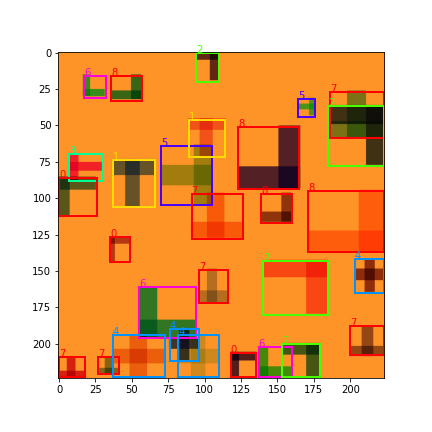

In [10]:
image_data = ImageData.from_dict(next(iter(dataset)))
image_data.draw_boxes()

# Build dataset (batched) and FPN detection model 

In [11]:
import keras_detection.datasets.datasets_ops as datasets_ops

def aug_fn(image_data: ImageData) -> ImageData:
    image = tf.cast(image_data.features.image, tf.float32)
    # example augmentation 
    image_shape = tf.shape(image)
    image = image + tf.random.uniform(minval=-10.0, maxval=10.0, shape=image_shape)
    return image_data.replace_image(image)


image_dim = 224
batch_size = 8
shuffle_buffer_size = 1 # we don't have to shuffle random rectangles dataset
num_classes = 9 # random rectangles have 9 classes
num_parallel_calls = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = datasets_ops.prepare_dataset(
    dataset,
    model_image_size=(image_dim, image_dim),
    augmentation_fn=aug_fn,
    num_epochs=-1,
    batch_size=batch_size ,
    shuffle_buffer_size=shuffle_buffer_size,
    prefetch_buffer_size=4,
    num_parallel_calls=num_parallel_calls
)

In [13]:
# %timeit next(iter(train_dataset))

# Build model builder 

In [14]:
from keras_detection import FPNBuilder
from keras_detection.tasks import standard_tasks
from keras_detection.backbones import resnet
import keras_detection.backbones.fpn as fpn
from keras_detection.utils import plotting
from keras_detection.heads import SingleConvPoolHeadFactory, SingleConvPoolHead

num_filters = 64

backbone = resnet.ResNetBackbone(
    input_shape=(image_dim, image_dim, 3),
    units_per_block=(1, 1, 1),
    num_last_blocks=2, # number of feature pyramids, setting single feature map
)

backbone = fpn.FPNBackbone(
    backbone, depth=num_filters, 
    num_first_blocks=1
)


faster_rcnn_tasks = [
    standard_tasks.get_box_shape_task(
        "box_shape",
        num_filters=num_filters,
        head_factory = SingleConvPoolHeadFactory(
            num_outputs=4,
            num_filters=num_filters,
            activation="relu",
            htype=SingleConvPoolHead,
        )
    ),
    standard_tasks.get_multiclass_task(
        num_classes,
        fl_gamma=0.0, label_smoothing=0, 
        activation='softmax', 
        head_factory = SingleConvPoolHeadFactory(
            num_outputs=num_classes + 1,
            num_filters=num_filters,
            activation="softmax",
            htype=SingleConvPoolHead,
        )
    ),
]

INFO:tensorflow:Building FPN module with inputs: [(56, 56, 64), (28, 28, 128), (14, 14, 256)]
INFO:tensorflow:FPN outputs with inputs:
INFO:tensorflow: => (None, 14, 14, 64)
INFO:tensorflow: => (None, 28, 28, 64)
INFO:tensorflow: => (None, 56, 56, 64)


In [15]:
backbone.output_shapes

[(56, 56, 64)]

In [16]:
from keras_detection.models.faster_rcnn_builder import FasterRCNNBuilder
faster_rcnn_builder = FasterRCNNBuilder(
    backbone = backbone,
    rpn_objectness_task = standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin", quantizable=False),
    rpn_box_shape_task = standard_tasks.get_box_shape_task("box_shape", quantizable=False),
    rcnn_tasks = faster_rcnn_tasks,
)

[(56, 56, 64)]


In [17]:
faster_rcnn_model = faster_rcnn_builder.build(batch_size=batch_size, is_training=True)

INFO:tensorflow:Input image: (8, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.fpn.FPNBackbone object at 0x7fdbc2954630>
INFO:tensorflow:Processing RPN feature maps for tasks: ['objectness', 'box_shape']WARNING:tensorflow:AutoGraph could not transform <bound method Socket.send of <zmq.sugar.socket.Socket object at 0x7fdc29264ce0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fdc470c6c00> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fdc470c6c00> is not a module, class, 

In [18]:
prepared_train_dataset = faster_rcnn_builder.prepare_dataset(train_dataset)
prepared_train_dataset

<MapDataset shapes: ({image: (8, 224, 224, 3), inputs/rpn/fm56x56/objectness: (8, 56, 56, 2), inputs/rpn/fm56x56/box_shape: (8, 56, 56, 5), inputs/rcnn/fm56x56/box_shape: (8, 56, 56, 5), inputs/rcnn/fm56x56/classes: (8, 56, 56, 11)}, {rpn/fm56x56/objectness: (8, 56, 56, 2), rpn/fm56x56/box_shape: (8, 56, 56, 5)}), types: ({image: tf.float32, inputs/rpn/fm56x56/objectness: tf.float32, inputs/rpn/fm56x56/box_shape: tf.float32, inputs/rcnn/fm56x56/box_shape: tf.float32, inputs/rcnn/fm56x56/classes: tf.float32}, {rpn/fm56x56/objectness: tf.float32, rpn/fm56x56/box_shape: tf.float32})>

In [19]:
faster_rcnn_model.input_names

['image',
 'inputs/rpn/fm56x56/objectness',
 'inputs/rpn/fm56x56/box_shape',
 'inputs/rcnn/fm56x56/box_shape',
 'inputs/rcnn/fm56x56/classes']

In [20]:
faster_rcnn_model.output_names

['rcnn/fm56x56/box_shape',
 'rcnn/fm56x56/classes',
 'rpn/fm56x56/box_shape',
 'rpn/fm56x56/objectness']

In [21]:
features, labels = next(iter(prepared_train_dataset))
features.keys(), labels.keys()

(dict_keys(['image', 'inputs/rpn/fm56x56/objectness', 'inputs/rpn/fm56x56/box_shape', 'inputs/rcnn/fm56x56/box_shape', 'inputs/rcnn/fm56x56/classes']),
 dict_keys(['rpn/fm56x56/objectness', 'rpn/fm56x56/box_shape']))

In [22]:
faster_rcnn_model.predict(features).keys()

INFO:tensorflow:Processing RPN feature maps for tasks: ['objectness', 'box_shape']
INFO:tensorflow: Processing RPN feature map (rpn/fm56x56)
sampled_boxes: Tensor("model_1/roi_sampling_layer/GatherV2:0", shape=(8, 64, 4), dtype=float32)
INFO:tensorflow:Processing RCNN feature maps for tasks: ['box_shape', 'classes']
INFO:tensorflow: Processing RCNN feature map (rcnn/fm56x56)


dict_keys(['rpn/fm56x56/objectness', 'rpn/fm56x56/box_shape', 'rcnn/fm56x56/box_shape', 'rcnn/fm56x56/classes'])

In [23]:
# faster_rcnn_model.summary()
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
faster_rcnn_model.compile(optimizer, **faster_rcnn_builder.rpn.get_model_compile_args())

In [25]:
faster_rcnn_model.fit(prepared_train_dataset, epochs=10, steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 59s 118ms/step - loss: 32.2671 - rpn/fm56x56/box_shape_loss: 0.0716 - rpn/fm56x56/objectness_loss: 0.1324 - rpn/fm56x56/objectness_ObjectnessPrecisionAT20pc: 0.0263 - rpn/fm56x56/objectness_ObjectnessRecallAT20pc: 0.0764 - rpn/fm56x56/objectness_ObjectnessPositivesMeanScore: 0.0802 - rpn/fm56x56/objectness_ObjectnessNegativesMeanScore: 0.0560 - rcnn/fm56x56/box_shape: 30.2271 - rcnn/fm56x56/classes: 1.1913
Epoch 2/10
500/500 [==============================] - 53s 106ms/step - loss: 31.4994 - rpn/fm56x56/box_shape_loss: 0.0797 - rpn/fm56x56/objectness_loss: 0.1005 - rpn/fm56x56/objectness_ObjectnessPrecisionAT20pc: 0.0777 - rpn/fm56x56/objectness_ObjectnessRecallAT20pc: 0.1317 - rpn/fm56x56/objectness_ObjectnessPositivesMeanScore: 0.0981 - rpn/fm56x56/objectness_ObjectnessNegativesMeanScore: 0.0288 - rcnn/fm56x56/box_shape: 29.5099 - rcnn/fm56x56/classes: 1.0918
Epoch 3/10
500/500 [==============================] - 55s 111ms/step - l

In [ ]:
# faster_rcnn_model.summary(line_length=150)

In [27]:
faster_rcnn_model.save_weights(filepath="model.h5")

In [52]:
features, labels = next(iter(prepared_train_dataset))
features.keys(), labels.keys()

(dict_keys(['image', 'inputs/rpn/fm56x56/objectness', 'inputs/rpn/fm56x56/box_shape', 'inputs/rcnn/fm56x56/box_shape', 'inputs/rcnn/fm56x56/classes']),
 dict_keys(['rpn/fm56x56/objectness', 'rpn/fm56x56/box_shape']))

In [53]:
predictions = faster_rcnn_model.predict(features)
predictions.keys()

dict_keys(['rpn/fm56x56/objectness', 'rpn/fm56x56/box_shape', 'rcnn/fm56x56/box_shape', 'rcnn/fm56x56/classes'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


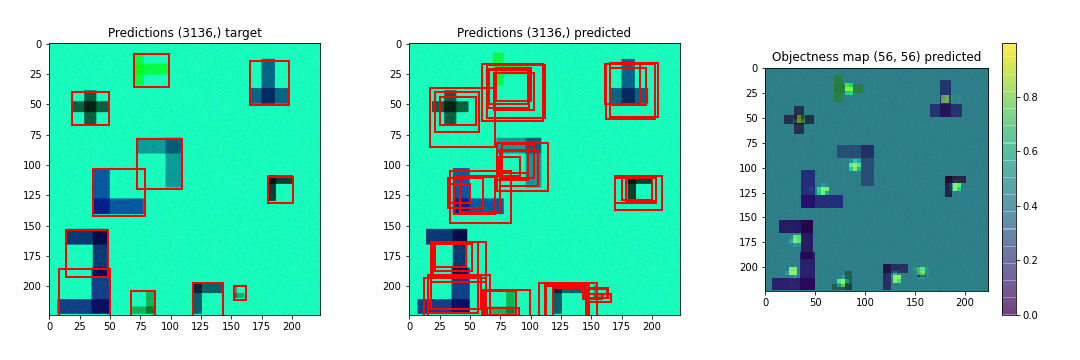

In [55]:
rpn_predictions = [predictions[name] for name in faster_rcnn_builder.rpn.get_outputs_names()]
rpn_predictions = faster_rcnn_builder.rpn.predictions_to_dict(rpn_predictions, postprocess=True)
# predictions = builder.predictions_to_dict(predictions, postprocess=True)
rpn_fm = "rpn/fm56x56"
rpn_targets = [labels[n][..., :-1] for n in faster_rcnn_builder.rpn.get_outputs_names()]
rpn_targets = faster_rcnn_builder.rpn.predictions_to_dict(rpn_targets, postprocess=True)

idx = 1
score_threshold = 0.5

rpn_target = dict(
    objectness=rpn_targets[f'{rpn_fm}/objectness'][idx],
    boxes_shape_map=rpn_targets[f'{rpn_fm}/box_shape'][idx],
)

predicted=dict(
    objectness=rpn_predictions[f'{rpn_fm}/objectness'][idx],
    boxes_shape_map=rpn_predictions[f'{rpn_fm}/box_shape'][idx],
)

render = plotting.draw_compares(    
    target=rpn_target,
    predicted=predicted,
    draw_fns=[
        plotting.draw_boxes, 
        # plotting.draw_classes_map,
        plotting.draw_objectness_map,
        # plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=score_threshold,
)
render

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


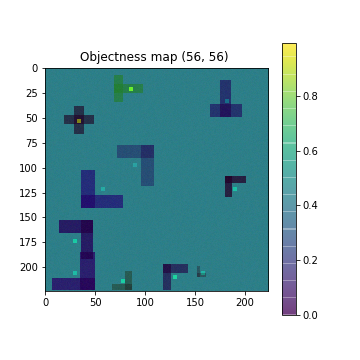

In [70]:
rpn_boxes, rpn_loss_map = faster_rcnn_builder.rpn.get_rpn_loss_map(
    [tf.constant(predictions[name]) for name in faster_rcnn_builder.rpn.get_outputs_names()], 
    labels
)
plotting.draw_objectness_map(image=features['image'][idx] / 255, objectness=rpn_loss_map[idx] / 154)

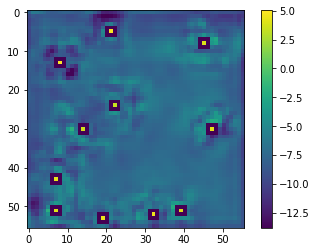

In [75]:
import matplotlib.pyplot as plt
plt.imshow(np.log(rpn_loss_map[idx] + 1e-6))
plt.colorbar()

## Prepare labels (targets) for objectness, box shape regression and classes

In [ ]:
def prepare_targets(batch_data):
    features, targets = builder.get_build_training_targets_fn()(batch_data)
    _, rcnn_targets = rcnn_builder.get_build_training_targets_fn()(batch_data)
    targets.update(rcnn_targets)
    return features, targets

In [ ]:
prepared_train_dataset = train_dataset.map(prepare_targets)
# prepared_rcnn_train_dataset = train_dataset.map(rcnn_builder.get_build_training_targets_fn())

In [ ]:
prepared_train_dataset

In [ ]:
features, labels = next(iter(prepared_train_dataset))

Validating targets: objectness, box prediction and class predictions heads

In [ ]:
fm = "fm56x56"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 0
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
#     classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
#         plotting.draw_classes_map,
        plotting.draw_objectness_map,
#         plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

# Train standard Keras model and export to TFLite 

In [ ]:
dataset_iterator = iter(prepared_train_dataset)

In [ ]:
features, labels = next(dataset_iterator)

In [ ]:
*predictions, feature_map = model(features)
predictions_raw = builder.predictions_to_dict(predictions, postprocess=False)

In [ ]:
compile_args = builder.get_model_compile_args()
prediction_losses = compile_args["loss"]
loss_weights = compile_args['loss_weights']

losses = []
for key, loss_class in prediction_losses.items():
    loss_class.per_anchor_loss = True
    loss = loss_class.call(y_true=labels[key], y_pred=predictions_raw[key])
    weight = loss_weights[key]
    losses.append(loss * weight)
    loss_class.per_anchor_loss = False
    
losses = tf.add_n(losses)

In [ ]:
predictions_post = builder.predictions_to_dict(predictions, postprocess=True)
box_shape_key = f'{fm}/box_shape'

boxes = box_shape_target.target_builder.to_tf_boxes(predictions_post[box_shape_key])

In [ ]:
from keras_detection.targets import feature_map_sampling as fm_sampling
from keras_detection.layers.roi_align import ROIAlignLayer
from keras_detection import LabelsFrame

num_samples = 64
crop_size = (32, 32)
roi_align = ROIAlignLayer(crop_size=crop_size)

indices = fm_sampling.scores_to_gather_indices(losses, num_samples)
# fm_sampling.sample_feature_map(tf.expand_dims(losses, -1), indices)

sampled_boxes = fm_sampling.sample_feature_map(boxes, indices)
frame = LabelsFrame(
    boxes=sampled_boxes, 
    num_rows=tf.constant([num_samples] * batch_size)
)

crops = roi_align([feature_map, frame])
crops.shape

In [ ]:
crops_targets = {}
for key, target in labels.items():
    target = fm_sampling.sample_feature_map(target, indices)
    crops_targets[key] = tf.reshape(target, [batch_size * num_samples, -1])
    
crops_targets.keys(), target.shape

In [ ]:
# crops_targets

In [ ]:
rcnn_outputs = rcnn_builder.build_heads_forward([crops])
rcnn_predictions_raw = rcnn_builder.predictions_to_dict(rcnn_outputs, postprocess=False)
rcnn_predictions_raw.keys()

In [ ]:
compile_args = rcnn_builder.get_model_compile_args()
rcnn_prediction_losses = compile_args["loss"]
rcnn_loss_weights = compile_args['loss_weights']

rcnn_losses = []
for key, loss_class in rcnn_prediction_losses.items():
    print(key)
    old_key = key.replace("32", "56")
    y_true = crops_targets[old_key]
    y_pred = rcnn_predictions_raw[key]
    y_true = tf.expand_dims(tf.expand_dims(y_true, axis=1), axis=1)
    y_pred = tf.expand_dims(tf.expand_dims(y_pred, axis=1), axis=1)
    loss = loss_class.call(y_true=y_true, y_pred=y_pred)
    weight = rcnn_loss_weights[key]
    rcnn_losses.append(loss * weight)


In [ ]:
import keras_detection.models.utils as kd_utils

l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

In [ ]:
!mkdir --parents models
model.save_weights("models/non-quantized-model.h5")

In [ ]:
model.load_weights("models/non-quantized-model.h5")

## Test trained model

In [ ]:
def draw_predictions(model, features, labels, idx = 0, fm = "fm28x28", score_threshold = 0.5):
  
  predictions = model.predict(features)
  predictions = builder.predictions_to_dict(predictions, postprocess=True)

  
  targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
  targets = builder.predictions_to_dict(targets, postprocess=True)

  target=dict(
      objectness=targets[f'{fm}/objectness'][idx],
      boxes_shape_map=targets[f'{fm}/box_shape'][idx],
      classes_map=targets[f'{fm}/classes'][idx],
  )

  predicted=dict(
      objectness=predictions[f'{fm}/objectness'][idx],
      boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
      classes_map=predictions[f'{fm}/classes'][idx],
  )

  render = plotting.draw_compares(    
      target=target,
      predicted=predicted,
      draw_fns=[
          plotting.draw_boxes, 
          plotting.draw_classes_map,
          plotting.draw_objectness_map,
          plotting.draw_classes_max_score_map,
      ],
      image=features['image'][idx] / 255,
      score_threshold=score_threshold,
  )
  return render


features, labels = next(iter(prepared_train_dataset))
draw_predictions(model, features, labels)

## Export model to tflite

In [ ]:
# creates two versions of the model:  
#  - models/non-quantized-model.tflite
#  - models/non-quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(    
    model, 
    save_path="models/non-quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between (per image data)
    num_dataset_samples = 64, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=True # Use represenetative dataset to create integer quantized model
)

In [ ]:
tflite_models_paths

# Train Quantized model and export to TFLite

In [ ]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5" # initialize weight from previous model
)

In [ ]:
# heads are not quantized (they have quantizable = Fales)
quantized_model.summary()

In [ ]:
# check if resnet is quantized
quantized_model.layers[2].summary()

In [ ]:
# check first head
quantized_model.layers[3].summary()

In [ ]:
# test metrics after quantization, they should be worse
# we can evaluate on train dataset since every batch is different
builder.evaluate_model(quantized_model, train_dataset, 100)

In [ ]:
# quantized_model.metrics_names

In [ ]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=2, steps_per_epoch=500)

quantized_model.save_weights("models/quantized-model.h5")

In [ ]:
quantized_model.load_weights("models/quantized-model.h5")

In [ ]:
# features, labels = next(iter(prepared_train_dataset))
draw_predictions(quantized_model, features, labels)

In [ ]:
builder.evaluate_model(quantized_model, train_dataset, 100)

In [ ]:
# creates one TFLite version of the model:  
#  - models/quantized-model.tflite

exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 64, # representative dataset number of samples, used when convert_quantized_model is True
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # full integer quantization  does not work with QAT models
)

# Benchmark models

In [ ]:
import keras_detection.evaluation.detection_metrics as det_metrics
from keras_detection.ops.python_ops import map_nested_dict
from pathlib import Path

In [ ]:
all_tflite_paths = [
  ('Keras', False ,'models/non-quantized-model.h5'), # Keras model
  ('Keras => TFLite', False ,'models/non-quantized-model.tflite'), # from Keras model
  ('Keras => TFLite (Post Quantized)', False ,'models/non-quantized-model.quantized.tflite'), # full post train quantization from Keras model
  ('Keras QAT => TFLite', False ,'models/quantized-model.tflite'), # from QAT model
  ('Keras QAT', True ,'models/quantized-model.h5') # a keras model 
]

In [ ]:
name, is_quantized, path = all_tflite_paths[0]
box_detector = builder.as_box_detector(path, is_quantized=is_quantized, iou_threshold=0.5)

In [ ]:
# Test on single prediction
train_dataset_iterator = iter(train_dataset)
batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
idx = 0
image_data = ImageData.from_dict(batch_data)
predictions = box_detector.predict(image_data.features.image)
predictions[idx].draw(image=image_data.features.image[idx], fontsize=20)

## Collecting metrics for few batches

In [ ]:
from collections import defaultdict

def benchmark_models(
    models_paths,
    num_batches_to_test = 1,
    iou_threshold = 0.5, # used for compuing metrics
):

  test_models = {
    name: builder.as_box_detector(path, is_quantized=is_quant, iou_threshold=0.5) 
    for name, is_quant, path in models_paths
  }

  test_models_metrics = defaultdict(list)

  print(f"Test models: {test_models.keys()}")

  for i in range(num_batches_to_test):
    print("Testing batch: ", i)
    batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
    image_data = ImageData.from_dict(batch_data)

    for k, predictor in test_models.items():
      print(f" => Predicting: {k}")
      predictions_per_image = predictor.predict(image_data.features.image)
      targets_per_image = image_data.labels.unbatch()
      
      metrics = []
      for target, predicted in zip(targets_per_image, predictions_per_image):
        metrics += det_metrics.image_precision_recall_metrics(
            target=target.replace(weights=None), predicted=predicted.to_labels_frame(), 
            iou_threshold=iou_threshold
        )
      test_models_metrics[k] += metrics
  return test_models_metrics


benchmark_metrics = benchmark_models(all_tflite_paths, num_batches_to_test=5)

In [ ]:
import pandas as pd
data = defaultdict(list)
for model_name, metrics in benchmark_metrics.items():
  for m in det_metrics.aggregate_metrics(metrics):
    data[m.name].append(m.value)
  data["model"].append(model_name)

pd.DataFrame(data).set_index("model")

# Train Quantized model for short time

In [ ]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5" # initialize weight from previous model
)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=1, steps_per_epoch=100)

optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=1, steps_per_epoch=100)

quantized_model.save_weights("models/quantized-model-short-train.h5")

In [ ]:
exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model-short-train.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 64, # representative dataset number of samples, used when convert_quantized_model is True
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # full integer quantization  does not work with QAT models
)

# Benchmark model

In [ ]:
all_tflite_paths_with_short = all_tflite_paths + [
  ('Keras QAT => TFLite (short)', False ,'models/quantized-model-short-train.tflite'),
  ('Keras QAT (short)', True ,'models/quantized-model-short-train.h5')
]
benchmark_metrics = benchmark_models(all_tflite_paths_with_short, num_batches_to_test=5)

In [ ]:
data = defaultdict(list)
for model_name, metrics in benchmark_metrics.items():
  for m in det_metrics.aggregate_metrics(metrics):
    data[m.name].append(m.value)
  data["model"].append(model_name)

pd.DataFrame(data).set_index("model")